# DAMCC

The thesis paper is available [here]([URL_TO_PAPER](https://dl.acm.org/doi/10.1145/3642970.3655829)).

## Problem Statement

**Graphs:** Given a timestamp $t$, we represent each graph in the data as a tuple of its adjacency and node feature matrices:  

$$
G_t = (\mathbf{X}_t, \mathbf{A}_t)
$$

where  

$$
\mathbf{X}_t \in \mathbb{R}^{N \times F}, \quad \mathbf{A}_t \in \{0,1\}^{N \times N}
$$

Here, $N$ is the total number of nodes, and $F$ is the number of node features. We then represent a graph time series as a sequence of graphs over time:  

$$
(G_t)_{t=0}^T = (G_1, G_2, \dots, G_T)
$$

where $T$ is the last timestamp. For our synthetically generated datasets, we have more than one such sequence of graphs. Therefore, we represent the full dataset as a set of graph sequences:  

$$
\{(G_t^1)_{t=0}^T, (G_t^2)_{t=0}^T, \dots, (G_t^{L-1})_{t=0}^T, (G_t^L)_{t=0}^T \}
$$

Given an unseen graph $G_t$ from such a dataset, our task is to predict $G_{t+1}$.


In [1]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd

# Add the parent directory of utils to the Python path
sys.path.append(os.path.join(os.getcwd(), '..'))
# from utils.utils import display_data_nice

First, let us create the dataset. Let us generate a dataset based on the Barabási–Albert (BA) model. BA is a widely used algorithm in network science for generating scale-free networks, which are characterized by a power-law degree distribution. See [wikipedia]([URL_TO_PAPER](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model))
 for more details. For us, it suffices us to know that this is some non-random sequence of graphs. We generate a BA dataset via a yaml config file in the data directory. Lets use the ba.yaml as an example. 

In [2]:
# Generate data using the specified YAML configuration file
# -c: path to the configuration file
# -p: path to the directory where the generated data will be saved
# -d: name of the dataset
!python ../data/generate_data.py \
    -c ../data/data_configs/ba.yaml \
    -p ../data/datasets \
    -d ba

100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.50it/s]
12


This process yields a list of 12 graph sequences with 6 graphs in each sequence each of which is a networkx.Graph object. Let us now see what this generated data looks like. Let us use the first sequence out of the three.

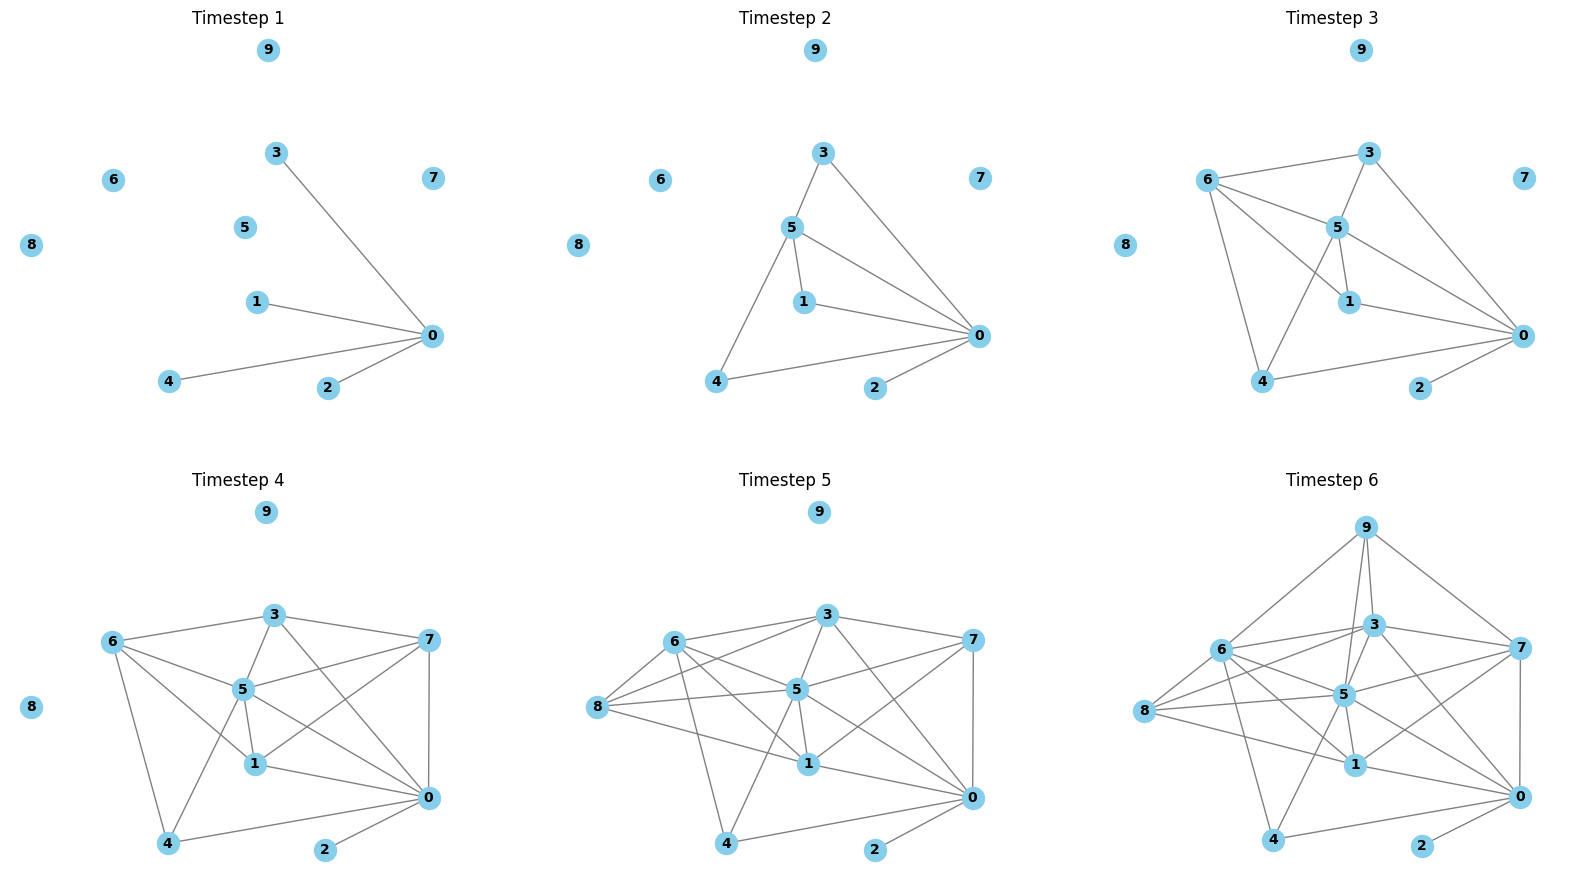

In [3]:
# Open the dataset file and load the data using pickle
with open('../data/datasets/ba.pkl', 'rb') as file:
    data = pickle.load(file)

# Set up the positions for the nodes for plotting using spring layout
# Use a fixed seed for reproducibility
graph = data[0][-1]
pos = nx.spring_layout(graph, seed=4)  
pos[2] = [0.1, -0.5]  # Manually adjust the position of node 2

# Plot the first graph in the data list
fig, axes = plt.subplots(2, len(data[0]) // 2, figsize=(20, 11))
axes = axes.flatten()  # Flatten the 2D array of axes

# Iterate over each graph in the first sequence and plot it
for i, graph in enumerate(data[0]):
    ax = axes[i]
    nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=250, edge_color='gray', 
            font_size=10, font_color='black', font_weight='bold', ax=ax)
    ax.set_title(f"Timestep {i+1}")

# Display the plot
plt.show()


Then, we need to preprocess to separate to train, validate , and test:


In [4]:
# Preprocess the data using the specified dataset file
# -d: path to the dataset file
# -s: path to the directory where the processed data will be saved
# -t: proportion of the data to be used for training
# -v: proportion of the data to be used for validation
# -r: whether to shuffle the data (False means no shuffling)
!python ../data/preprocess_data.py \
    -d ../data/datasets/ba.pkl \
    -s ../data/processed_datasets/ba/graph_data/ \
    -t 0.5 \
    -v 0.5 \
    -r False

Randomizing
Number of Training TS:  3
Number of Val TS:  3
Number of Test TS:  6
TS length (T):  6
Saving Graphs
6
6
6
Computing Deltas
Converting to networkx format
100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 524.66it/s]
Setting attributes.
100%|████████████████████████████████████████| 15/15 [00:00<00:00, 35464.80it/s]
Computing Deltas
Converting to networkx format
100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 2741.26it/s]
Setting attributes.
100%|███████████████████████████████████████| 15/15 [00:00<00:00, 100023.15it/s]


You should now have the following files in the data directory:
ba_test_graphs_raw.pkl  ba_train_graphs.pkl  ba_train_graphs_raw.pkl  ba_val_graphs.pkl  ba_val_graphs_raw.pkl. The files with no -raw suffix are for DAMNETS and AGE models. Let us now see processed format of our data:

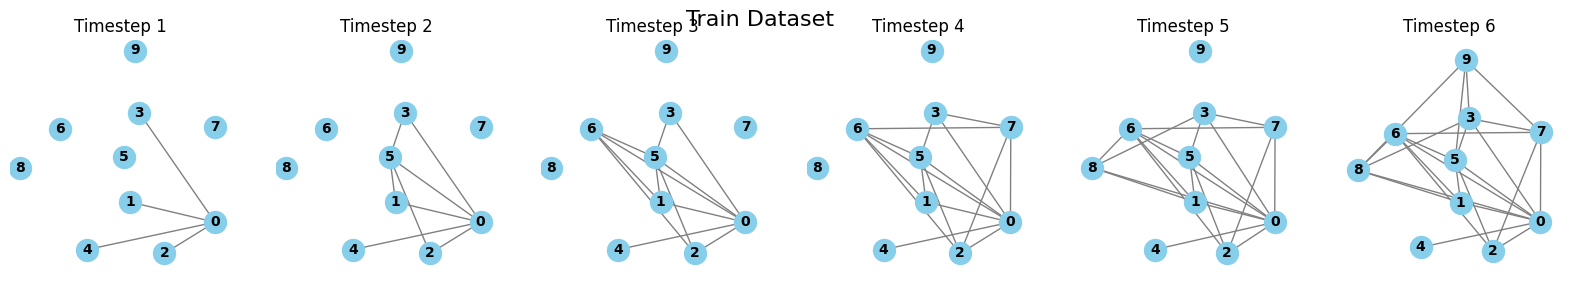

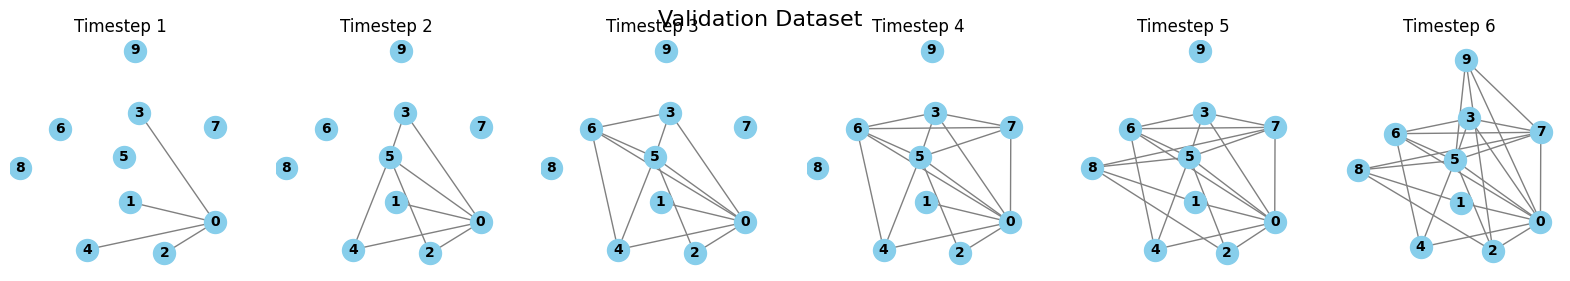

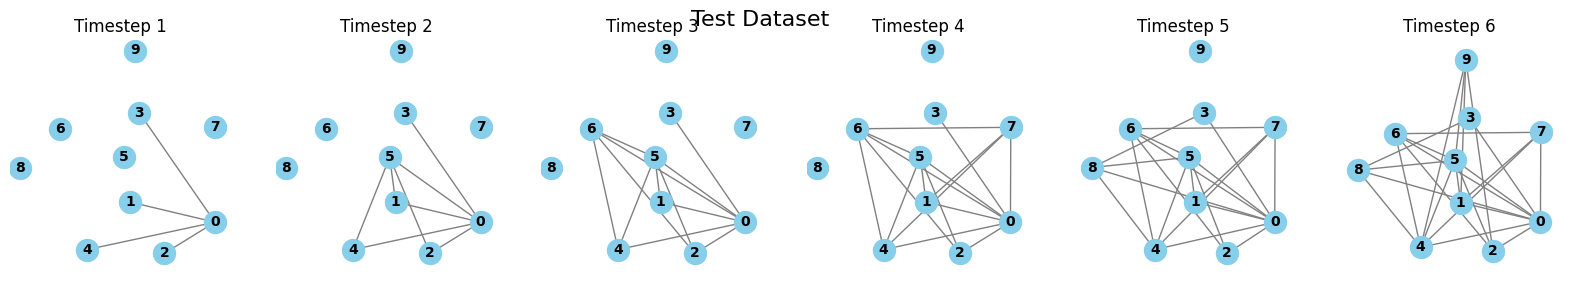

In [5]:
# The non-raw datasets are for the DAMNETS model
# Load the training dataset
with open('../data/processed_datasets/ba/graph_data/ba_train_graphs_raw.pkl', 'rb') as file:
    train_data = pickle.load(file)

# Load the validation dataset
with open('../data/processed_datasets/ba/graph_data/ba_val_graphs_raw.pkl', 'rb') as file:
    val_data = pickle.load(file)

# Load the test dataset
with open('../data/processed_datasets/ba/graph_data/ba_test_graphs_raw.pkl', 'rb') as file:
    test_data = pickle.load(file)

# Combine the datasets into a list for easier iteration
datasets = [train_data, val_data, test_data]
dataset_names = ['Train', 'Validation', 'Test']

# Iterate over each dataset and plot the graphs
for dataset, name in zip(datasets, dataset_names):
    # Create a figure with subplots for each graph in the dataset
    fig, axes = plt.subplots(1, len(dataset[0]), figsize=(20, 3))
    axes = axes.flatten()  # Flatten the 2D array of axes

    # Iterate over each graph in the dataset and plot it
    for i, graph in enumerate(dataset[0]):
        ax = axes[i]
        nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=250, edge_color='gray', 
                font_size=10, font_color='black', font_weight='bold', ax=ax)
        ax.set_title(f"Timestep {i+1}")

    # Set the title for the entire figure
    fig.suptitle(f"{name} Dataset", fontsize=16)
    plt.show()

All looks in order. Let us now convert these graphs to CC format:

In [6]:
# Lift the training graphs to CC format and save the output
!python ../utils/process_graph_to_cc.py -i ../data/processed_datasets/ba/graph_data/ba_train_graphs_raw.pkl -o ../data/processed_datasets/ba/CC_data

# Lift the validation graphs to CC format and save the output
!python ../utils/process_graph_to_cc.py -i ../data/processed_datasets/ba/graph_data/ba_val_graphs_raw.pkl -o ../data/processed_datasets/ba/CC_data

# Lift the test graphs to CC format and save the output
!python ../utils/process_graph_to_cc.py -i ../data/processed_datasets/ba/graph_data/ba_test_graphs_raw.pkl -o ../data/processed_datasets/ba/CC_data

Converting graphs to ccs
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 496.07it/s]
Converting graphs to ccs
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 663.34it/s]
Converting graphs to ccs
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 589.79it/s]
Setting x_0
100%|██████████████████████████████████████████| 6/6 [00:00<00:00, 35098.78it/s]
Setting x_0
100%|██████████████████████████████████████████| 6/6 [00:00<00:00, 74017.13it/s]
Setting x_0
100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 4854.52it/s]
Data saved to ../data/processed_datasets/ba/CC_data/ba_train_ccs.pkl
Converting graphs to ccs
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 309.53it/s]
Converting graphs to ccs
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 470.65it/s]
Converting graphs to ccs
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 424.63it/s]
Setting x_0
100%

Its is difficult to visualise CC's so we won't. We now train the model:

In [7]:
# Train the DAMCC model using the specified parameters
# --train: flag to indicate training mode
# --data_name: name of the dataset
# --train_file: path to the training data file in CC format
# --val_file: path to the validation data file in CC format
# --save_dir: directory where the trained model and other outputs will be saved
# --max_epochs: maximum number of training epochs
# --lr: learning rate for the optimizer
!python ../run_damcc.py \
    --train \
    --data_name ba \
    --train_file ../data/processed_datasets/ba/CC_data/ba_train_ccs.pkl \
    --val_file ../data/processed_datasets/ba/CC_data/ba_val_ccs.pkl \
    --save_dir ../experiments \
    --max_epochs 2 \
    --lr 0.001

Using device: cpu
  0%|                                                    | 0/15 [00:00<?, ?it/s]At Epoch 1:
/opt/anaconda3/envs/damcc_eval/lib/python3.11/site-packages/topomodelx/nn/combinatorial/hmc_layer.py:680: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:56.)
  A_p = torch.sparse.mm(A_p, neighborhood)
generating rows

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 26.72it/s]
generating rows

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 123.97it/s]
RETURNING INCIDENCE MATRIX
incidence matrix size was:  4
new size:  8
generating rows

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 425.17it/s]
generating rows

100%|████████████████████████████████████████████| 1/1 [

We now test:

In [8]:
# Run the DAMCC model in test mode using the specified parameters
# --test: flag to indicate test mode
# --data_name: name of the dataset
# --test_file: path to the test data file in CC format
# --test_graphs_file: path to the raw test graphs file
# --model_path: path to the trained model file
# --save_dir: directory where the test results and other outputs will be saved
!python ../run_damcc.py \
    --test \
    --data_name ba \
    --test_file ../data/processed_datasets/ba/CC_data/ba_test_ccs.pkl \
    --test_graphs_file ../data/processed_datasets/ba/graph_data/ba_test_graphs_raw.pkl \
    --model_path ../experiments/last_experiment/best_val_model.pth \
    --save_dir ../experiments/last_experiment/

Using device: cpu
/opt/anaconda3/envs/damcc_eval/lib/python3.11/site-packages/topomodelx/nn/combinatorial/hmc_layer.py:680: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:56.)
  A_p = torch.sparse.mm(A_p, neighborhood)
generating rows
100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 284.90it/s]
generating rows
100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 279.11it/s]
RETURNING INCIDENCE MATRIX
incidence matrix size was:  4
new size:  8
generating rows
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 751.80it/s]
generating rows
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.66it/s]
RETURNING INCIDENCE MATRIX
incidence matrix size was:  1
new size:  2
g

Let us see what the Sampled graphs look like:

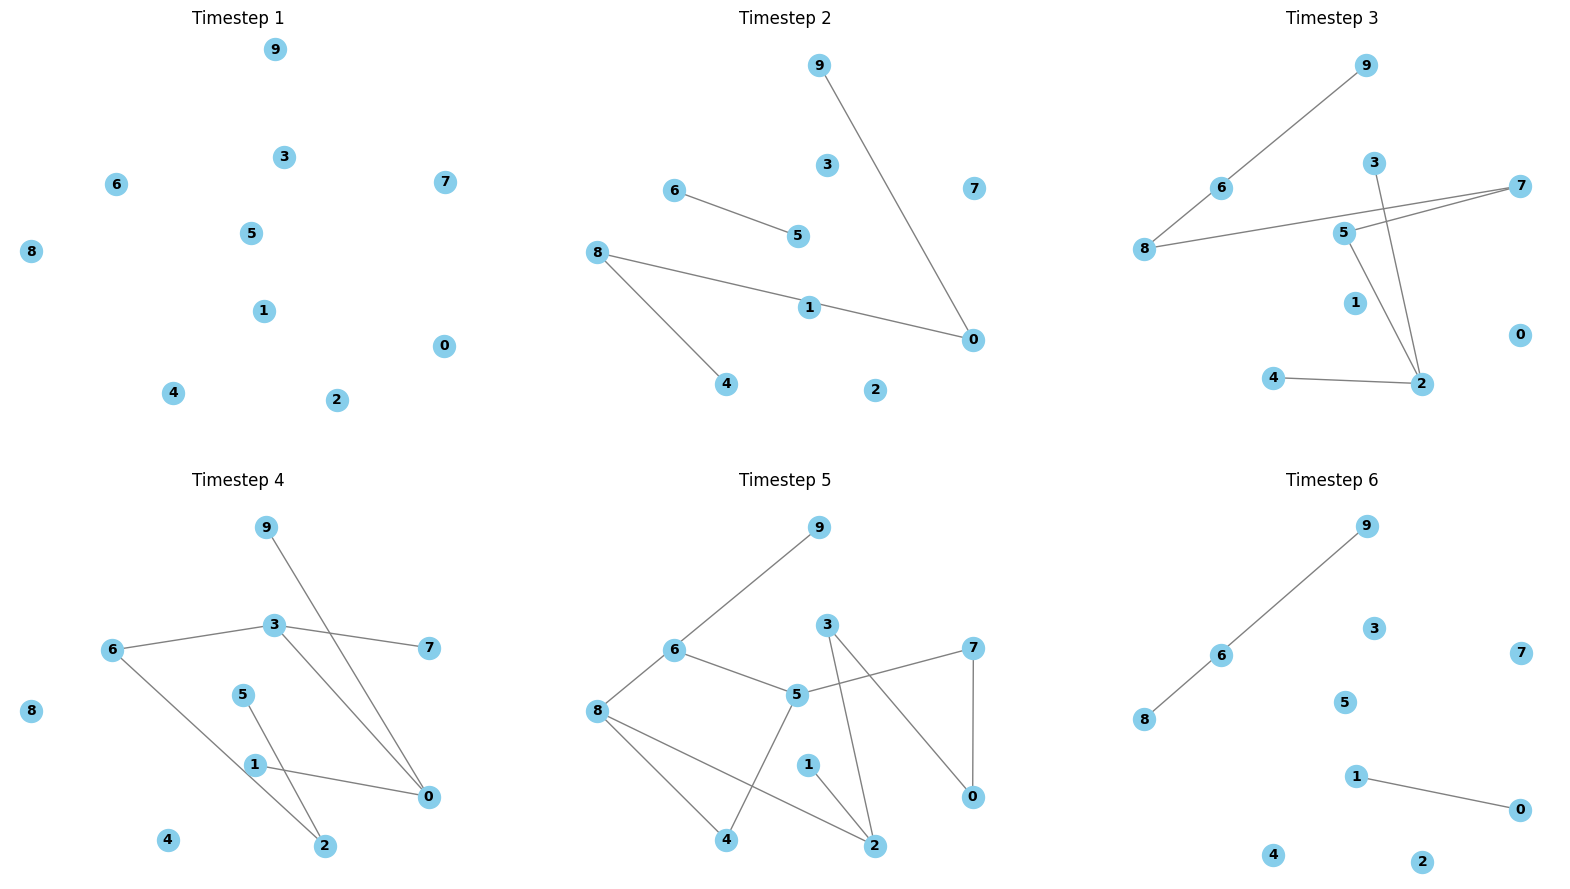

In [9]:
# Open the file containing the generated data and load it using pickle
with open('../experiments/last_experiment/test/sampled_graphs.pkl', 'rb') as file:
    generated_data = pickle.load(file)

# Create a figure with subplots for each graph in the first sequence of generated data
fig, axes = plt.subplots(2, len(generated_data[0]) // 2, figsize=(20, 11))
axes = axes.flatten()  # Flatten the 2D array of axes

# Iterate over each graph in the first sequence of generated data and plot it
for i, graph in enumerate(generated_data[0]):
    ax = axes[i]
    nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=250, edge_color='gray', 
            font_size=10, font_color='black', font_weight='bold', ax=ax)
    ax.set_title(f"Timestep {i+1}")

# Display the plot
plt.show()


We now evaluate. Note that in the original paper we us ethe evaluation teqchniques introduced in [this link](https://dl.acm.org/doi/10.1145/3642970.3655829). The code for that is not available as teh authors asked it to not be shared. However the evaluation we provide here is from [DAMNETS](https://arxiv.org/abs/2203.15009) and originally available on [github](https://github.com/jase-clarkson/DAMNETS_LoG).

In [19]:
!python ../eval.py \
    --sampled_path ../experiments/last_experiment/test/sampled_graphs.pkl \
    --test_path ../data/processed_datasets/ba/graph_data/ba_test_graphs_raw.pkl \
    --dataset_name ba \
    --model_name damcc \
    --output_dir ../eval

Computing statistics for model damcc
Computing Density
Computing Clustering
Computing Transitivity
Computing Assortativity
Computing Closeness
Computing statistics for model Test
Computing Density
Computing Clustering
Computing Transitivity
Computing Assortativity
Computing Closeness
Computing Local MMDs
100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 97.93it/s]
------ Sum MMDs ------
damcc  Degree_MMD        1.193602
       Clustering_MMD    4.556618
       Spectral_MMD      0.652966
       Trans_MMD         1.815586
       Assort_MMD        1.054388
       CC_MMD            0.721815
dtype: float64


In [22]:
import pandas as pd
print(pd.__version__)

2.2.3


In [23]:
from IPython.display import Image

# Display the image
Image(filename='../eval/damcc_network_statistics.jpg', width=2000, height=300)

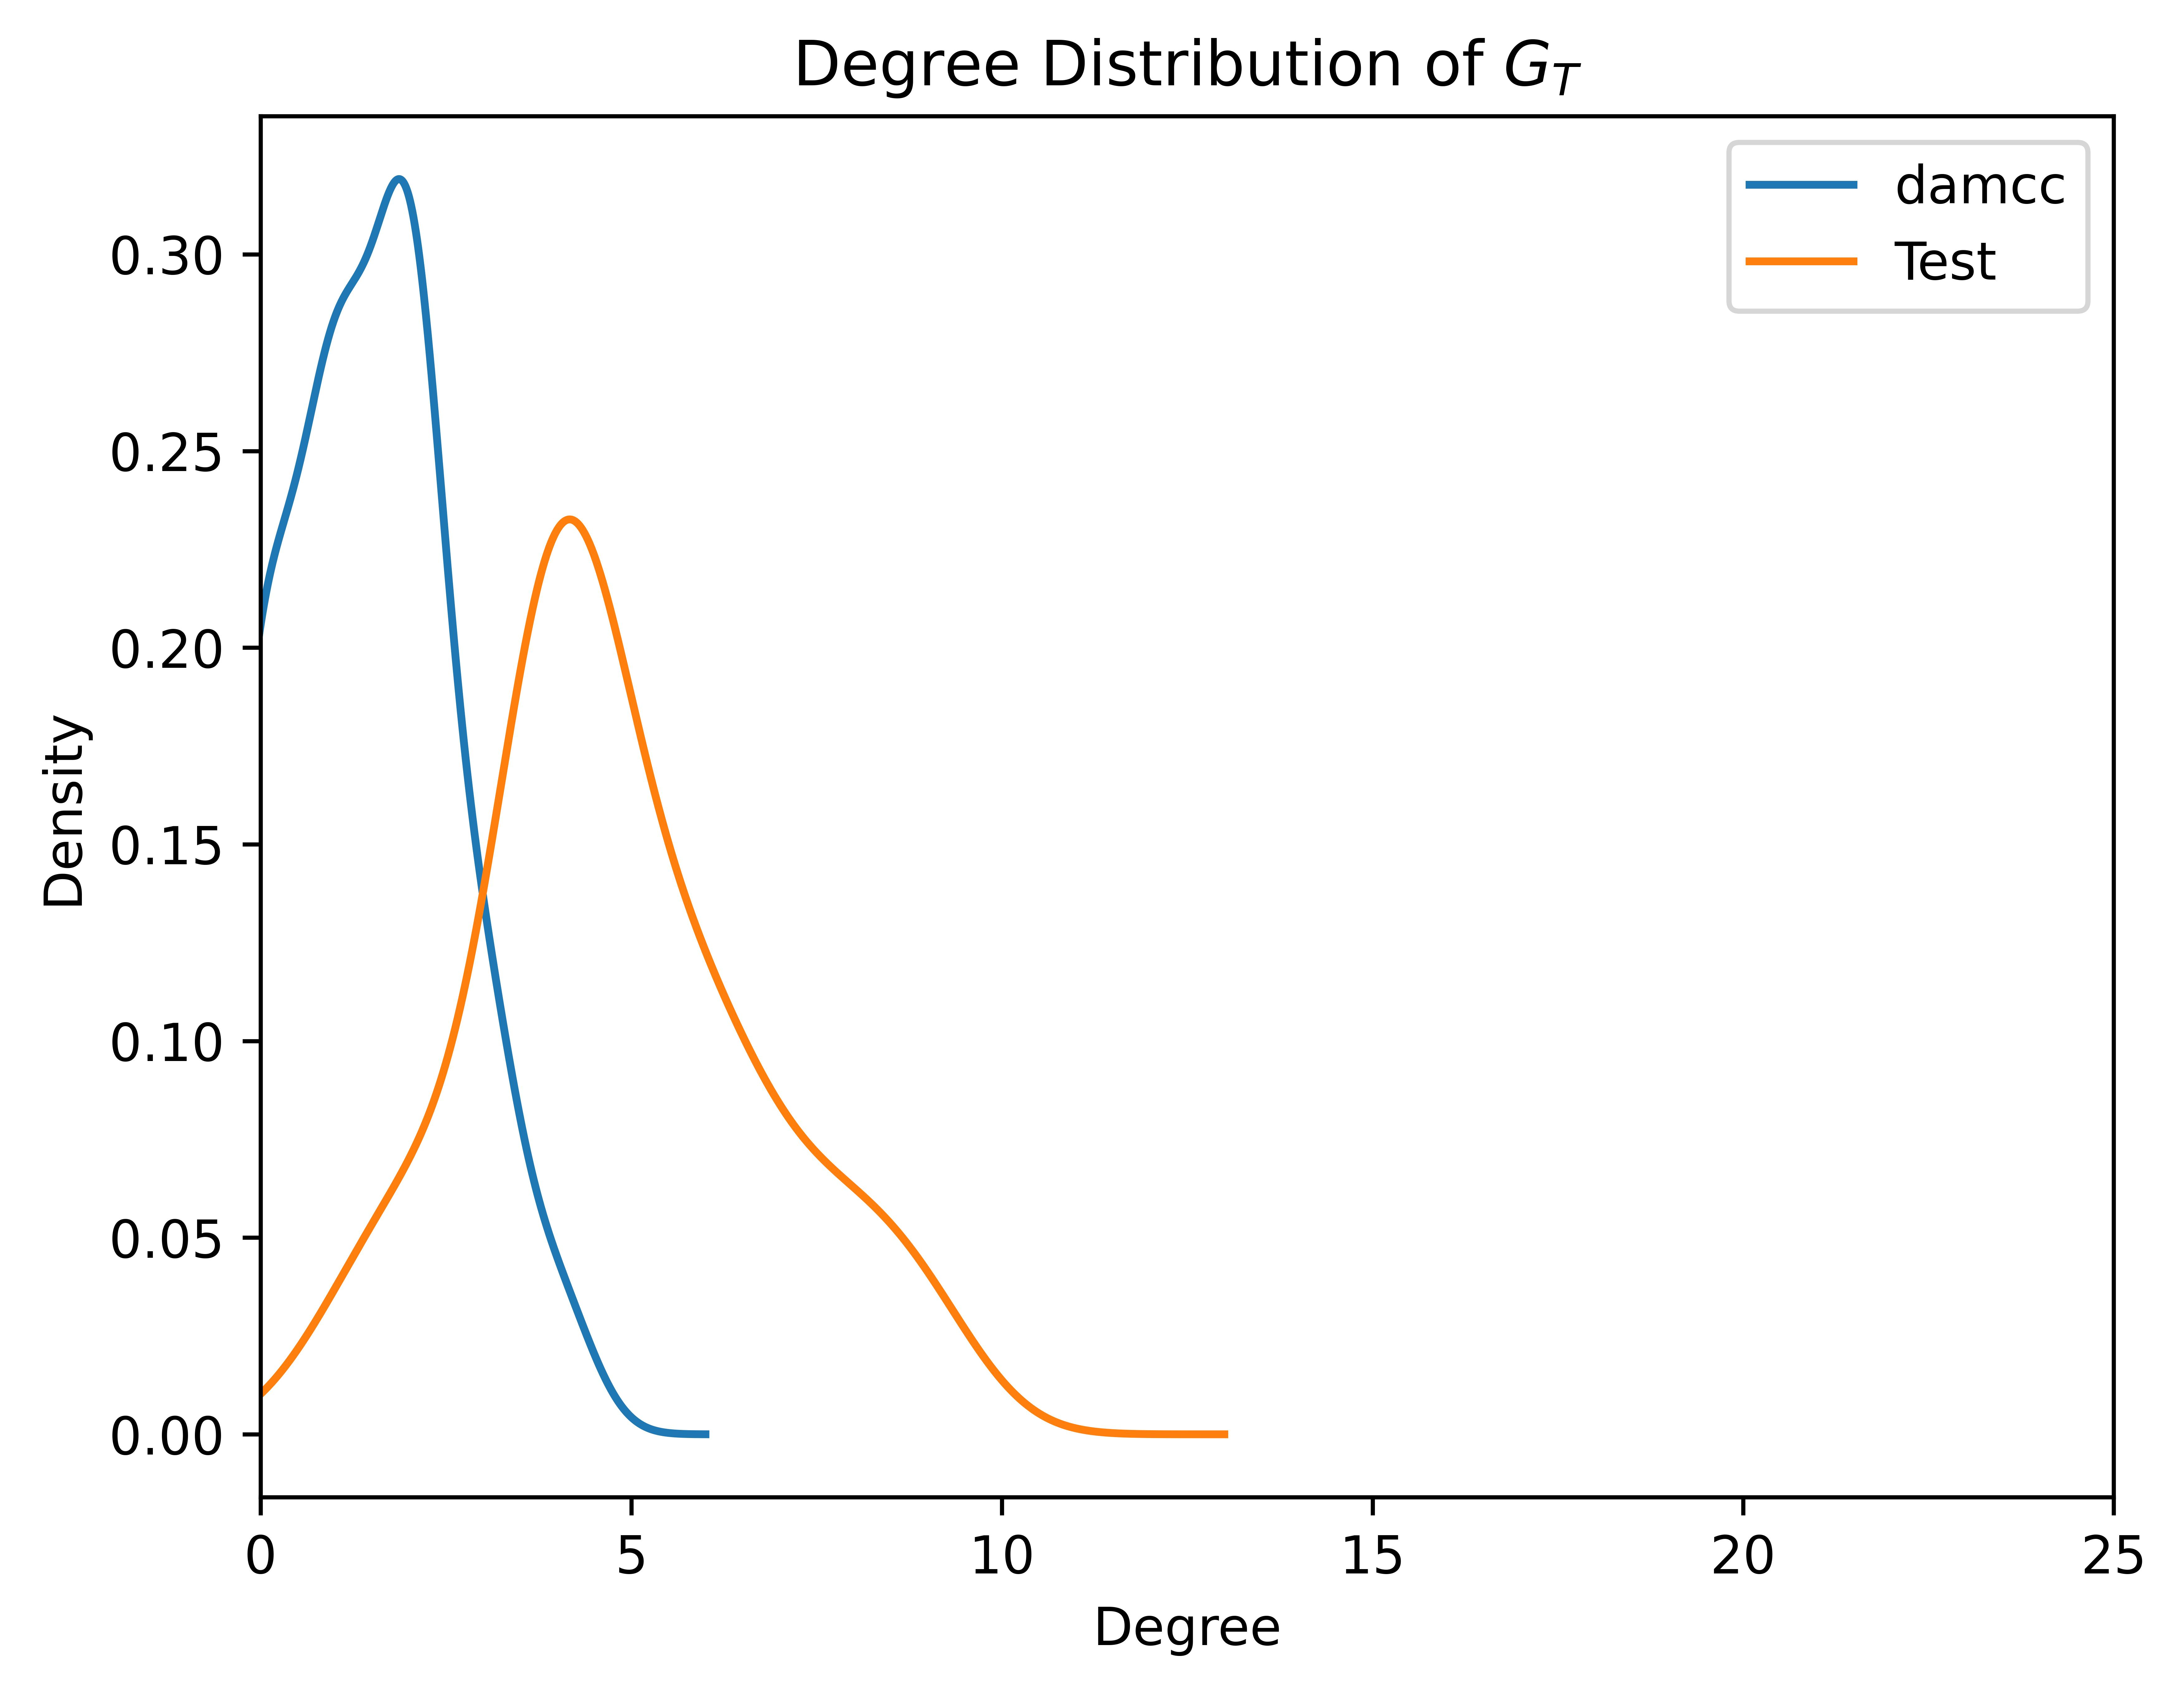

In [24]:
Image(filename='../eval/damcc_ba_degree.jpg', width=800)